# ECE 5831 Final Project: Chest X-Ray Pneumonia Detection Using ResNet and Transfer Learning
#### Nathan Bagnall

In [ ]:
import torch
#colab stuff to enable faster training
from google.colab import drive, files
drive.mount('/content/drive')
colab = True
#detect GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Mounted at /content/drive
cuda:0


In [ ]:
!nvidia-smi

Wed Dec  9 13:32:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    13W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Introduction

This project is a continuation of my midterm project reviewing and experimenting with ResNet and ImageNet. The goal of this project is to implement ResNet in a real use case on a real dataset, specifically on detecting Pneumonia in chest x-rays from [this Kaggle dataset]('https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia') with at least 80%+ accuracy.

## Importing libraries and images

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import models
import torchvision.transforms as torchtrans
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix, f1_score
from mlxtend.plotting import plot_confusion_matrix
import os
import time
import copy

#folder where data was extracted
if colab:
  xray_data = '/content/drive/MyDrive/chest_xray/chest_xray'
else:
  xray_data = 'C:/Users/bagna/Nextcloud/College/2019-2020/ECE 5831/final project/chest_xray/chest_xray'

#setup pytorch dataset to resize, crop, and convert images to tensors
image_transforms = torchtrans.Compose([torchtrans.Resize(250), torchtrans.CenterCrop(244), torchtrans.ToTensor()])

#used in attempt to combat overfitting
image_trans_more = torchtrans.Compose([torchtrans.Resize(250), torchtrans.RandomRotation(180), torchtrans.CenterCrop(244), torchtrans.ToTensor()])

#defining microbatch size and threads (in colab this did not show to have a large effect on performance)
batch_size = 4
workers = 4

train_data = ImageFolder(xray_data + '/train', image_transforms)
test_data = ImageFolder(xray_data + '/test', image_transforms)
val_data = ImageFolder(xray_data + '/val', image_transforms)

dataloader_train = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = workers)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = workers)
dataloader_val = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle = True, num_workers = workers)

print(train_data)

#creating new data indices for training and validation splits
dataset = train_data
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(.1 * dataset_size))
np.random.seed(18)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

#creating PT data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

new_train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler = train_sampler)
new_test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler = valid_sampler)

Dataset ImageFolder
    Number of datapoints: 5840
    Root location: /content/drive/MyDrive/chest_xray/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=250, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(244, 244))
               ToTensor()
           )


<Figure size 800x600 with 0 Axes>

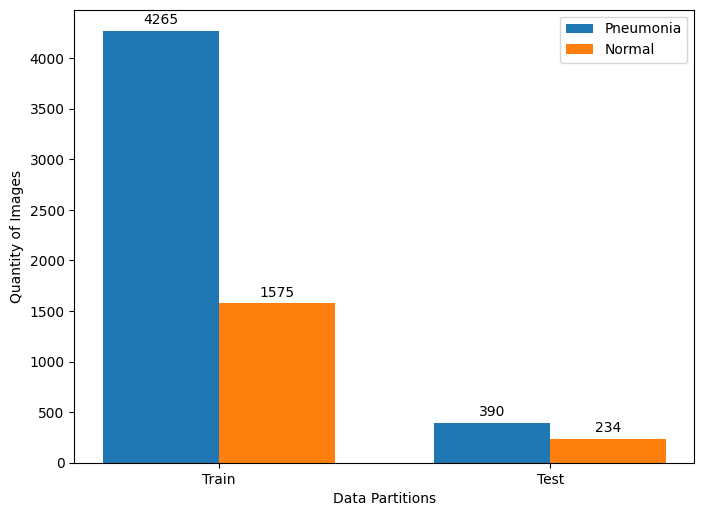

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

plt.figure()

plot_labels = ['Train', 'Test']
normal_len = [1575, 234]
pneumonia_len = [4265, 390]

x = np.arange(len(plot_labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pneumonia_len, width, label = 'Pneumonia')
rects2 = ax.bar(x + width/2, normal_len, width, label = 'Normal')

# data_len.append(len(dataloader_train.dataset))
# data_len.append(len(dataloader_test.dataset))
plt.xlabel('Data Partitions')
ax.set_xticks(x)
ax.set_xticklabels(plot_labels)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

plt.ylabel('Quantity of Images')
plt.legend()


plt.show()

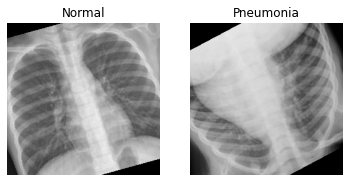

In [ ]:
%matplotlib inline
image_norm = 14
image_pneum = 3128

plt.figure()
plt.subplot(121)
plt.imshow(train_data[image_norm][0].permute(1, 2, 0))

if (train_data[image_norm][1] == 0):
  plt.title('Normal')
else:
  plt.title('Pneumonia')

plt.axis('off')

plt.subplot(122)
plt.imshow(train_data[image_pneum][0].permute(1, 2, 0))

if (train_data[image_pneum][1] == 0):
  plt.title('Normal')
else:
  plt.title('Pneumonia')

plt.axis('off')
plt.show()

## Initializing model

In [ ]:
def init_model(model_to_load = 'resnet50', output_size = 244, train_all_layers = False):

  if (model_to_load == 'resnet50'):
    model = models.resnet50(pretrained = True)
  elif (model_to_load == 'resnet18'):
    model = models.resnet18(pretrained = True)
  elif (model_to_load == 'resnet152'):
    model = models.resnet152(pretrained = True)

  #set each parmeter to not require finetuning unless reshaped
  if (train_all_layers == False):
    for param in model.parameters():
      param.requires_grad = False

  #reshaping the fully connected layer
  model.fc = nn.Linear(model.fc.in_features, num_classes)
  return model

#classes to decide between, originally resnet has 1000 from imagenet, but for this application there are only 2: normal, or pneumatic
num_classes = 2

#initializing model, pretrained is essential to avoid long training periods since the focus of this project is fine-tuning
model = init_model('resnet50', num_classes, False)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

After loading the model and reshaping it, the fully connected final layer now has 2 possible outputs instead of 1000.

In [ ]:
#display all parameters being trained
print('Parameters being updated:')
params = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params.append(param)
        print("\n", name)

#setup stochastic gradient descent optimizer
learn_rate = 0.001
learn_rate_fast = 0.01
momentum = 0.9
optimizer = optim.SGD(params, lr = learn_rate_fast, momentum = momentum)

Parameters being updated:

 fc.weight

 fc.bias


In [ ]:
#setup loss function and train model
#cross entropy is a common technique for loss functions when classifying, in this case classifying an image as pneumonia or normal
#define weight since there are more pneumonia than pictures than normal
weights = [1.0, 1575/4265]
weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight = weights)

#epochs to train for
num_epochs = 20

start_time = time.time()

#validation history
vald_accuracy_hist = []

best_model = copy.deepcopy(model.state_dict())
best_accuracy = 0.0

#send model to device
model = model.to(device)
print('Model moved to ' + str(device))

for epoch in range(num_epochs):
    print('Epoch: ' + str(epoch) + '/' + str(num_epochs - 1))

    #train and validate each epoch
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_correct = 0
        
        if phase == 'train':
            data = dataloader_train
        else:
            data = dataloader_test

        for inputs, labels in data:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #initialize parameter gradients
            optimizer.zero_grad()

            #record history while training
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(data.dataset)
        epoch_acc = running_correct.double() / len(data.dataset)

        print(phase + ' Loss: ' + str(epoch_loss) + ' Accuracy: ' + str(epoch_acc))

        if phase == 'val' and epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            best_model = copy.deepcopy(model.state_dict())
        if phase == 'val':
            vald_accuracy_hist.append(epoch_acc)
        
        #newline
        print()
        time_elapsed = time.time() - start_time
        print('Total training time so far: ' + str(time_elapsed))

time_elapsed = time.time() - start_time
print('Training completed in ' + str(time_elapsed))
print('Best val Acc: ' + str(best_accuracy))

model.load_state_dict(best_model)

#save model
torch.save(model.state_dict(), 'checkpoint.pth')
files.download('checkpoint.pth')

Model moved to GPU
Epoch: 0/19
train Loss: 2.9705082444767203 Accuracy: tensor(0.8096, device='cuda:0', dtype=torch.float64)

Total training time so far: 101.1511025428772
val Loss: 2.4616822331429784 Accuracy: tensor(0.8942, device='cuda:0', dtype=torch.float64)

Total training time so far: 111.89271855354309
Epoch: 1/19
train Loss: 2.7335153486728108 Accuracy: tensor(0.8396, device='cuda:0', dtype=torch.float64)

Total training time so far: 212.56402826309204
val Loss: 1.498828873108448 Accuracy: tensor(0.8558, device='cuda:0', dtype=torch.float64)

Total training time so far: 223.09419870376587
Epoch: 2/19
train Loss: 2.8804375391767207 Accuracy: tensor(0.8474, device='cuda:0', dtype=torch.float64)

Total training time so far: 323.4769630432129
val Loss: 3.0522568187440102 Accuracy: tensor(0.8926, device='cuda:0', dtype=torch.float64)

Total training time so far: 333.9712917804718
Epoch: 3/19
train Loss: 2.5555185957648465 Accuracy: tensor(0.8599, device='cuda:0', dtype=torch.float6

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, ' Accuracy')

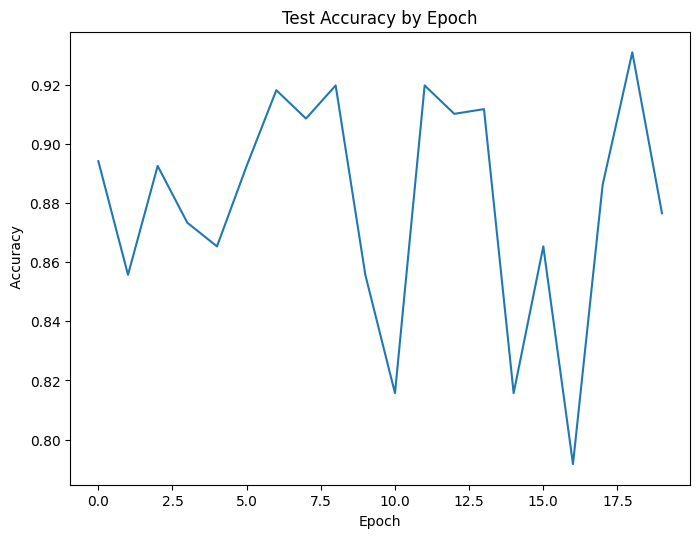

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

plt.figure()
plt.plot(vald_accuracy_hist)
plt.title('Test Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel(' Accuracy')

## Evaluating trained models

In [ ]:
# #load trained model

# #fc only
# res18 = '/content/drive/MyDrive/checkpoint_res18_20_epoch.pth'
# res50 = '/content/drive/MyDrive/checkpoint_res50_20_epoch.pth'
# res152 = '/content/drive/MyDrive/checkpoint_res152_20_epoch.pth'

# #full network
# res50_full = '/content/drive/MyDrive/checkpoint_resnet_50_full_model_epoch_50.pth'
# res18_fast = '/content/drive/MyDrive/checkpoint_res18_20_epoch_fast_learn.pth'

# model = init_model(models.resnet50(pretrained = True), 2)

# #load saved states
# state_dict = torch.load(res50_full)
# model.load_state_dict(state_dict)

#set model into evaluation mode to prevent weights from changing
model.eval()

#testing model on validation images not used during training or testing
correct = 0
total = 0

#setup arrays for stat calculations and plotting since dataloader loads in batches
all_groundtruth = np.empty([0], int)
all_predicted = np.empty([0], int)

#use test set (used to test while training) or validation set (unseen by model before this point, only 16 images)
# data = dataloader_val
data = dataloader_test

first_run = True

with torch.no_grad():
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)
        model = model.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        #add predicted values for this batch to total for aditional accuracy calcs
        if first_run:
          all_predicted = predicted.cpu().numpy()
          all_groundtruth = labels.cpu().numpy()
        else:
          all_predicted = np.append(all_predicted, predicted.cpu().numpy())
          all_groundtruth = np.append(all_groundtruth, labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        first_run = False

print('Accuracy of the network on the ' + str(len(data.dataset)) + ' images: ' + str(
    100 * correct / total))

Accuracy of the network on the 624 images: 93.10897435897436


In [ ]:
print(f1_score(all_groundtruth, all_predicted, pos_label=1))

0.9443725743855109


<Figure size 800x600 with 0 Axes>

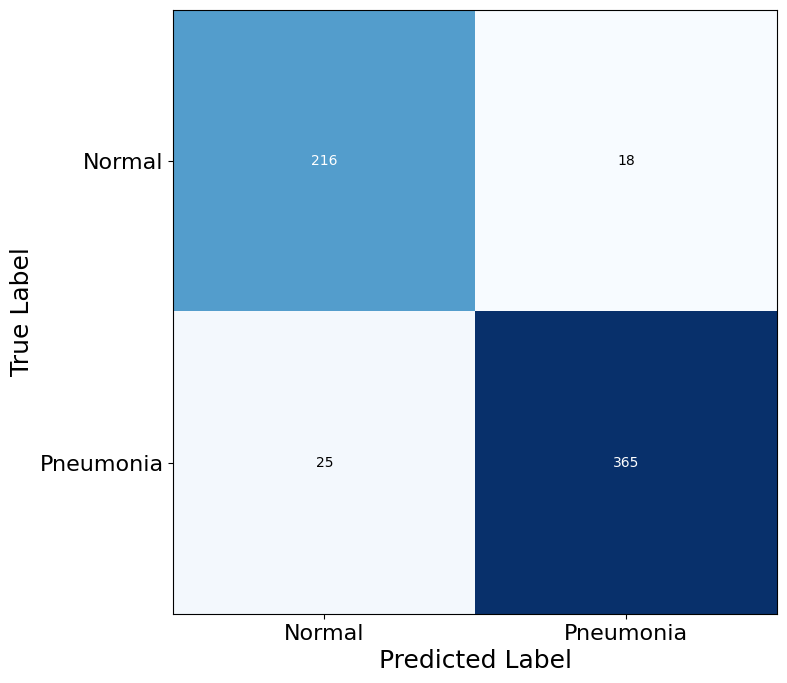

In [ ]:
#plot accuracy/ lost over epochs
#plot confusion matrix
cm  = confusion_matrix(all_groundtruth, all_predicted)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

#demo of a few images
